# **Making Song Recommendation with Neural Collaborative Filtering**

***
With the neural network collaborative filtering (NNCF), we were able to make song recommendation for existing playlists. Here we used the NNCF model trained on the subset of data with randomly selected 10,000 playlists and demonstrated how we recommend new songs to those existing playlists. 
<br/><br/>
The idea is to choose the songs that have the highest scores predicted by the network when paired with a specific playlist. We can then compute the Jaccard index of recommended songs and existing songs, and compare it to the Jaccard index between existing songs, and that between not-recommended songs and exisiting songs. A good recommendation would have a high Jaccard index (comparable to Jaccard index between existing songs).

***
First we load all the libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.sparse as sps
import scipy
import pickle
import keras
from keras.models import load_model
import itertools
%matplotlib inline
sns.set()

Using TensorFlow backend.


## Load data and model

***
Here we loaded the sparse matrix containing track-playlist contingency, as well as the NNCF model.

In [2]:
# load files
sps_acc = scipy.sparse.load_npz('sparse_10000_rand.npz')

# convert matrix to csc type
sps_acc = sps_acc.tocsc()
sps_acc

<171381x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 657056 stored elements in Compressed Sparse Column format>

In [3]:
# load the best NNCF model
model_file = "models_10000_rand/model.200-0.50-0.76.h5"
model = load_model(model_file)

# find track and playlist number
n_tracks, n_playlists = sps_acc.shape[0], sps_acc.shape[1]

## Define functions
***
Then we define several functions.

- ***recommend_tracks***
This function makes recommendation of tracks that are not currently in a specific playlist. It returns the list of tracks that were predicted by the network as class 1 but have real label class 0, sorted by the score.

- ***get_jaccard***
This function calculated the Jaccard index between a pair of tracks.

- ***create_unique_pair_subset*** and ***create_pairs_btw_lists*** help creating pairs of tracks from given lists.

In [4]:
# this function returns the indices and scores for recommeded tracks given a playlist_id
def recommend_tracks(sps_acc, playlist_ind, model):
    pairs = [np.ones((n_tracks,))*playlist_ind, np.arange(n_tracks)]

    # make prediction with the model
    prob = model.predict(pairs)
    pred_class = prob.argmax(axis=-1)

    # extract real class label from original data
    real_class = np.array(sps_acc[:,playlist_ind].toarray()).reshape(-1,)
    
    # real tracks: real class one
    real_one_ind = np.argwhere(real_class).reshape(-1,)
    
    # recommended tracks: predicted class one but real class zero
    recom = np.logical_and(pred_class == 1, real_class == 0)

    # find recommeded track index and score of being one
    recom_ind = np.argwhere(recom).reshape(-1,)
    recom_prob = prob[recom_ind,1]

    # sort recommended indices from highest score to lowest
    recom_sort_ind = np.argsort(recom_prob)
    recom_ind = recom_ind[recom_sort_ind[::-1]]

    # not-recommended tracks: predicted class zero and real class zero
    not_recom = np.logical_and(pred_class == 0, real_class == 0)

    # find not-recommeded track index and score of being zero
    not_recom_ind = np.argwhere(not_recom).reshape(-1,)
    not_recom_prob = prob[not_recom_ind,0]

    # sort not-recommended indices from highest score to lowest
    not_recom_sort_ind = np.argsort(not_recom_prob)
    not_recom_ind = not_recom_ind[not_recom_sort_ind[::-1]]


    return recom_ind, not_recom_ind, real_one_ind

In [5]:
# this function return jaccard index between a pair of tracks
def get_jaccard(sps_acc, pair):
    pair = list(pair)
    track1 = pair[0]
    track2 = pair[1]

    mem = np.array(sps_acc[pair,:].toarray())

    mem1 = np.argwhere(mem[0,:]).reshape(-1,)
    mem2 = np.argwhere(mem[1,:]).reshape(-1,)

    intersect = list(set(mem1) & set(mem2))
    union = list(set(mem1) | set(mem2))
    jaccard = len(intersect)/len(union)
    
    return jaccard

In [6]:
# this function creates a subset of unique pair of a given list of tracks
def create_unique_pair_subset(track_list, num):
    track_list = list(track_list)
    track_pairs = [(track1, track2) for i, track1 in enumerate(track_list) 
               for j, track2 in enumerate(track_list) if i<j]
    total_num = len(track_pairs)
    if total_num > num:
        sub_ind = list(np.random.choice(total_num, num, replace=False))
        track_pair_subset = [pair for idx, pair in enumerate(track_pairs) if idx in sub_ind]
    else:
        track_pair_subset = track_pairs
    
    return track_pair_subset

In [7]:
# this function creates all pairs between 2 given lists of tracks
def create_pairs_btw_lists(track_list1, track_list2):
    track_list1 = list(track_list1)
    track_list2 = list(track_list2)
    track_pairs = [(track1, track2) for track1 in track_list1 for track2 in track_list2]
    return track_pairs

## Make recommendation for one playlist
***
Here we randomly selecte a playlist, and make recommendation of the top 10 songs with the highest scores predicted by the NNCF model. We then compute Jaccard index between the recommended songs and existing songs (***rec vs. real***), and compare that to Jaccard index between exisitng songs (***btw real***), and Jaccard index between exisitng songs and 10 randomly selected non-recommended songs (***not-rec vs. real***). Jaccard inex for ***Rrandom pairs*** of tracks was also computed as baseline.

In [10]:
# randomly select one playlist and make recommendation
playlist_id = np.random.choice(n_playlists, 1)[0]

# number of recommended tracks
num_rec = 10

# get recommendation from NN model
rec, not_rec, real = recommend_tracks(sps_acc, playlist_id, model)

# restrict number of real tracks to no more than 50
if real.shape[0] > 50:
    real = real[np.random.choice(real.shape[0], 50, replace=False)]

# select rec and not_rec
rec = rec[:num_rec]
not_rec = not_rec[np.random.choice(not_rec.shape[0], num_rec, replace=False)]

# calculate the pair number
pair_num = real.shape[0]*num_rec

# collect jaccard index for rec-real pairs
rec_real_pairs = create_pairs_btw_lists(rec, real)
rec_real_jac = [get_jaccard(sps_acc,i) for i in rec_real_pairs]

# collect jaccard index for real-real pairs
real_real_pairs = create_unique_pair_subset(real, pair_num)
real_real_jac = [get_jaccard(sps_acc,i) for i in real_real_pairs]

# collect jaccard index for not_rec-real pairs
not_rec_real_pairs = create_pairs_btw_lists(not_rec, real)
not_rec_real_jac = [get_jaccard(sps_acc,i) for i in not_rec_real_pairs]

# random pairs
rand_pair_num = 100
rand_id = list(np.random.choice(n_tracks, 2*rand_pair_num))
rand_pairs = [(tr1,tr2) for tr1 in rand_id[:rand_pair_num] 
              for tr2 in rand_id[rand_pair_num+1:] if tr1<tr2]
rand_jac = [get_jaccard(sps_acc,i) for i in rand_pairs]

print('Mean Jaccard index\n rec vs. real =',np.mean(rec_real_jac),
      '\n btw real =',np.mean(real_real_jac),
      '\n not_rec vs. real',np.mean(not_rec_real_jac),
      '\n random pair',np.mean(rand_jac))

Mean Jaccard index
 rec vs. real = 0.0081430460371861 
 btw real = 0.03138652210942226 
 not_rec vs. real 6.969834556041452e-05 
 random pair 0.00015164196090215217


### Visualize result
***
We can visualize the distribution of Jaccard index of 4 groups by plotting their empirical cumulative density functions. As we can see here, the ***rec vs. real*** group and ***btw real*** have distributions of higher Jaccard index, meaning that the tracks are similar to each other (even more similar for ***rec vs. real*** than ***btw real***), whereas the Jaccard index for ***not-rec vs. real*** group was really close to zero, comparable to ***random pairs*** of tracks. Therefore, the recommendation seems to be working well.

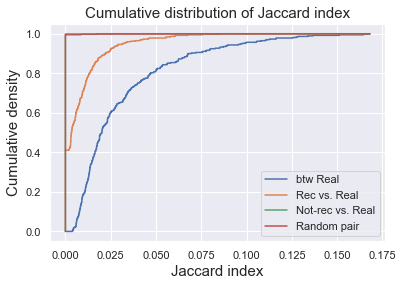

In [11]:
# visualize distribution of Jaccard index
ecdf1 = sm.distributions.ECDF(real_real_jac)
x1 = np.linspace(0, max(real_real_jac),1000)
y1 = ecdf1(x1)
plt.step(x1, y1,label='btw Real')

ecdf2 = sm.distributions.ECDF(rec_real_jac)
y2 = ecdf2(x1)
plt.step(x1, y2,label='Rec vs. Real')

ecdf3 = sm.distributions.ECDF(not_rec_real_jac)
x3 = np.linspace(0, max(real_real_jac),10000)
y3 = ecdf3(x3)
plt.step(np.concatenate((np.zeros(1,),x3)), np.concatenate((np.zeros(1,),y3)),label='Not-rec vs. Real')

ecdf4 = sm.distributions.ECDF(rand_jac)
y4 = ecdf4(x3)
plt.step(np.concatenate((np.zeros(1,),x3)), np.concatenate((np.zeros(1,),y4)),label='Random pair')

plt.legend(loc='best')
plt.title('Cumulative distribution of Jaccard index',fontsize = 15)
plt.xlabel('Jaccard index',fontsize = 15)
plt.ylabel('Cumulative density',fontsize = 15);

## Scale up for 100 playlists
***
We can scale up our recommendation to 100 randomly selected playlists and look at the statistics of the Jaccard index of each group.

In [14]:
# load random playlist subset that was used for SVD
with open('playlist_id_100_for_jaccard_SVD_rand.pkl','rb') as f1:
    playlist_subset = pickle.load(f1)
    
# create empty lists
mean_rec_real_jac = []
mean_real_real_jac = []
mean_not_rec_real_jac = []
mean_rand_jac = []

In [18]:
# loop over playlist subset to get jaccard index
for ii, playlist_id in enumerate(playlist_subset):
    # specify number of recommendation (=10 songs)
    num_rec = 10
    
    # get recommendation from NN model
    rec, not_rec, real = recommend_tracks(sps_acc, playlist_id, model)

    # restrict number of real tracks to no more than 50
    if real.shape[0] > 50:
        real = real[np.random.choice(real.shape[0], 50, replace=False)]

    # select rec and not_rec
    rec = rec[:num_rec]
    not_rec = not_rec[np.random.choice(not_rec.shape[0], num_rec, replace=False)]
    
    # calculate the pair number
    pair_num = real.shape[0]*num_rec

    # collect jaccard index for rec-real pairs
    rec_real_pairs = create_pairs_btw_lists(rec, real)
    rec_real_jac = [get_jaccard(sps_acc,i) for i in rec_real_pairs]
    mean_rec_real_jac.append(np.mean(rec_real_jac))

    # collect jaccard index for real-real pairs
    real_real_pairs = create_unique_pair_subset(real, pair_num)
    real_real_jac = [get_jaccard(sps_acc,i) for i in real_real_pairs]
    mean_real_real_jac.append(np.mean(real_real_jac))

    # collect jaccard index for not_rec-real pairs
    not_rec_real_pairs = create_pairs_btw_lists(not_rec, real)
    not_rec_real_jac = [get_jaccard(sps_acc,i) for i in not_rec_real_pairs]
    mean_not_rec_real_jac.append(np.mean(not_rec_real_jac))
    
    # random pairs
    rand_pair_num = 100
    rand_id = list(np.random.choice(n_tracks, 2*rand_pair_num))
    rand_pairs = [(tr1,tr2) for tr1 in rand_id[:rand_pair_num] 
                  for tr2 in rand_id[rand_pair_num+1:] if tr1<tr2]
    rand_jac = [get_jaccard(sps_acc,i) for i in rand_pairs]
    mean_rand_jac.append(np.mean(rand_jac))

### Visualization 
***
The boxplot below shows the distribution of mean Jaccard index of the 4 groups for the 100 playlists. The ***btw real*** had the highest Jaccard index, indicating high similarity between each pair. The ***rec vs. real*** had low but above zero Jaccard index. Jaccard index for ***not-rec vs. real group*** was close zero, showing low similarity (as ***random pairs*** of tracks). 

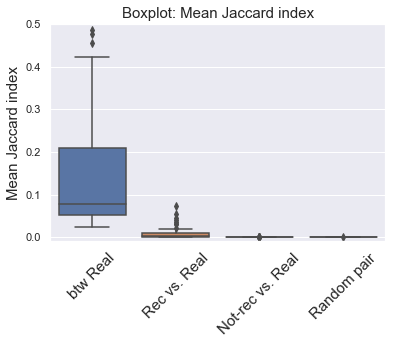

In [25]:
# result visualization
# put results into dataframe
all_jac = np.concatenate((np.array(mean_real_real_jac),
                          np.array(mean_rec_real_jac),
                          np.array(mean_not_rec_real_jac),
                          np.array(mean_rand_jac)))
label = np.concatenate((np.ones(100,),np.ones(100,)*2,
                        np.ones(100,)*3,np.ones(100,)*4))
jac_df = pd.DataFrame({'jac':all_jac, 'label': label})

# plot boxplot
ax = sns.boxplot(x='label', y='jac', data=jac_df)
plt.xticks([0.,1.,2.,3.], ['btw Real','Rec vs. Real','Not-rec vs. Real','Random pair'],
           fontsize = 15, rotation = 45)
plt.ylim([-0.01, 0.5])
plt.title('Boxplot: Mean Jaccard index',fontsize = 15)
plt.xlabel('')
plt.ylabel('Mean Jaccard index',fontsize = 15);

Zoomed in:

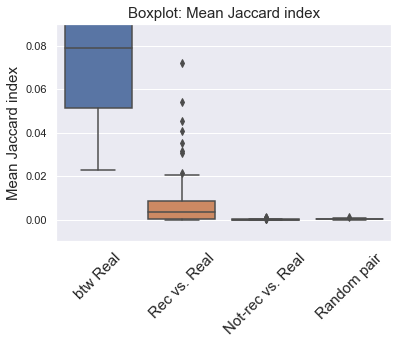

In [28]:
ax = sns.boxplot(x='label', y='jac', data=jac_df)
plt.xticks([0.,1.,2.,3.], ['btw Real','Rec vs. Real','Not-rec vs. Real','Random pair'],
           fontsize = 15, rotation = 45)
plt.ylim([-0.01, 0.09])
plt.title('Boxplot: Mean Jaccard index',fontsize = 15)
plt.xlabel('')
plt.ylabel('Mean Jaccard index',fontsize = 15);

In [38]:
# put result into a dict and save it
jaccard_dict = {}
jaccard_dict['rec_real'] = mean_rec_real_jac
jaccard_dict['real_real'] = mean_real_real_jac
jaccard_dict['not_rec_real'] = mean_not_rec_real_jac
jaccard_dict['rand_pair'] = mean_rand_jac

with open('jaccard_100_playlists_NNCF10000_rand.pkl','wb') as f0:
    pickle.dump(jaccard_dict, f0)
with open('playlist_id_100_for_jaccard_NNCF10000_rand.pkl','wb') as f1:
    pickle.dump(playlist_subset, f1)